In [19]:
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy.io
import random
import math
import itertools
import pandas as pd
from scipy import *
from scipy.optimize import minimize
from scipy.optimize import fmin
from scipy import ndimage
from scipy.ndimage import correlate
import mat73 # Para leer los archivos de images2.mat e images9.mat
import imagesc as imagesc
import cv2
import warnings
warnings.filterwarnings("ignore")

# Función para convertir un vector fila a vector columna.
def columna(vector):
    return np.array(np.matrix(vector)).T

Para este punto no se va a realizar partición de los datos en conjuntos de entrenamiento/validación. Los datos de entrenamiento son los mismos datos de validación. El objetivo de este putno es cosntruir una mini red convolucional que sea capaz de clasificar una imagen como dígito 2 o dígito 9. El primer paso es importar los datos.

In [20]:
# Se carga cada archivo de dígitos 2 y dígitos 9 y se guarda cada uno en su respectivo diccionario.
datos2 = mat73.loadmat('images2.mat')
datos9 = mat73.loadmat('images9.mat')

# a)

In [21]:
# Se sabe que se tienen 100 datos de dígitos 2 y 100 datos de dígitos 9
total_datos2 = 100
total_datos9 = 100
total_datos = total_datos2 + total_datos9

m2 = np.zeros((14,14))
m9 = np.zeros((14,14))

# Se crea una matriz en la que se guardan todos los datos del dígito 2
for i in range(total_datos2):
    digito = datos2['images2'][:,:,i]
    if i == 0:
        m2 = digito
    else:
        m2 = np.concatenate((m2, digito), axis=1)

# Se crea una matriz en la que se guardan todos los datos del dígito 9
for i in range(total_datos9):
    digito = datos9['images9'][:,:,i]
    if i == 0:
        m9 = digito
    else:
        m9 = np.concatenate((m9, digito), axis=1)

# Matriz con los datos de dígitos 2 y dígitos 9
m = np.concatenate((m2, m9), axis=1)
filas = np.shape(m)[0]
cols = np.shape(m)[1]

# Lista para guardar todos los dígitos, indexados de 0 a 199.
digitos = []
for j in range(0, cols, filas):
    digito = m[:filas, j:j+filas]
    digitos.append(digito)

w = np.ones((1,197))
h = columna([0,0,0,0,1,0,0,0,0])

# Definición de la función de salida de la red convolucional.
# Entradas
# w: vector fila de parámetros que representan los pesos de la red neuronal. El tamaño de este vector debe ser 1x(num_datos+1) para        tener en cuenta el término de bias.
# h: vector de parámetros de tamaño 9x1 para el kernel del filtrado.
# Salida
# yhat: vector de 1xm, donde m es el número de datos (neuronas de entrada) que contiene la función de activación evaluada para cada dato.
def fact(w, h):
    kernel = np.array([[float(h[0]), float(h[1]), float(h[2])], [float(h[3]), float(h[4]), float(h[5])], [float(h[6]), float(h[7]), float(h[8])]])
    p = np.concatenate((h, w.T), axis=0)
    Im = ndimage.convolve(m, kernel, mode='constant', cval=0.0)
    M = np.reshape(Im, (196, 200), order='F')
    suma = p[9] + (M.T)@p[10:]
    yhat = 1/(1+np.exp((suma)))

    return yhat

# b)

In [22]:
# Crear un vector que es 1 para dígito 2 (clase 1) y 0 para dígito 9 (clase 0).
y = np.ones((200,1))
y[100:] = np.zeros((100, 1))

# Definición de la función de error cuadrático. 
# Entradas:
# p: vector de variables igual a [w, h]^T
# l: parámetro de regularización lambda 
def error_cuad2(p, l):
    # Se extrae el vector w y el vector h del vector p ingresado por parámetro.
    # w: vector fila de parámetros que representan los pesos de la red neuronal. El tamaño de este vector debe ser 1x(num_datos+1) para        tener en cuenta el término de bias.
    # h: vector de parámetros de tamaño 9x1 para el kernel del filtrado.
    w = p[:filas*filas+1].T
    h = p[filas*filas+1:len(p)]
    # Se encuentra la salida de la red convolucional.
    yhat = fact(w, h)
    # Se evalúa el error obtenido para el w y el h ingresados por parámetro.
    error = np.sum(np.power((y-yhat), 2)) + l*(np.power(np.linalg.norm(w),2) + np.power(np.linalg.norm(h), 2))

    return error

In [33]:
# Función que realiza la optmización usando el método de Nelder-Mead.
def find_params(w, h, l, maxIter):
    p = np.concatenate((w.T, h), axis=0)
    res = columna(fmin(error_cuad2, p, args=(l,), disp=0, maxfun=80000, maxiter=400000))
    w_opt = res[:14*14+1]
    h_opt = res[14*14+1:len(p)]

    return w_opt, h_opt

# c) Error de clasificación


lambda: 0.001
errores_clase1: 54
errores_clase0: 26


lambda: 0.0677
errores_clase1: 54
errores_clase0: 26


lambda: 0.1344
errores_clase1: 46
errores_clase0: 30


lambda: 0.2011
errores_clase1: 55
errores_clase0: 28


lambda: 0.2678
errores_clase1: 47
errores_clase0: 29


lambda: 0.33449999999999996
errores_clase1: 48
errores_clase0: 29



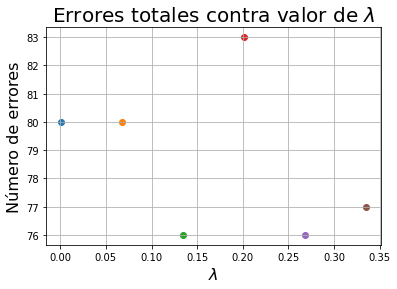

In [24]:
# Se crea un vector de parámetros w inicial y un vector de parámetros h inicial.
w_init = np.ones((1, 197))/np.shape(np.ones((1,197)))[1]
h_init = np.array([[0],[0],[0],[0],[1],[0],[0],[0],[0]])

# Variables de contadores de errores y clasificaciones correctas.
errores_clase1 = 0
errores_clase0 = 0
errores_totales = 0
clase1_correctos = 0
clase0_correctos = 0

# Número máximo de iteraciones permitidas.
maxIter = 400000

# Valores de lambda
val = 10
lambdas = []
for i in range(0, 6):
    lambdas.append((0.0667*i + 0.001))
# lambdas = [0.01, 0.1, 1, 10, 100, 1000, 10000]

# Evaluamos cuál valor de lambda es mejor.
for l in lambdas:

    print(f'\nlambda: {l}')
    w_opt, h_opt = find_params(w_init, h_init, l, maxIter)
    y_hat = fact(w_opt.T, h_opt)
    # print(f'\ny_hat = \n{y_hat}\n')
    
    for i in range(total_datos):
        if i < 100:
            if float(y_hat[i]) >= 0.5:
                clase1_correctos += 1
            else:
                errores_clase1 += 1
        elif i >= 100:
            if float(y_hat[i]) < 0.5:
                clase0_correctos += 1
            else:
                errores_clase0 += 1

    errores_totales = errores_clase1 + errores_clase0

    # Para cada lambda se imprime la cantidad de errores que el clasificador cometió.
    print(f'errores_clase1: {errores_clase1}')
    print(f'errores_clase0: {errores_clase0}\n')

    # Se grafica el error de la iteración actual con su respectivo valor de lambda.
    plt.scatter(l, errores_totales)
    plt.grid(b=True)
    plt.title('Errores totales contra valor de $\lambda$', fontsize=20)
    plt.xlabel('$\lambda$', fontsize=16)
    plt.ylabel('Número de errores', fontsize=16)

    # Se reinician los contadores para volver a graficar con el siguiente lambda.
    errores_clase1 = 0
    errores_clase0 = 0
    errores_totales = 0
    clase1_correctos = 0
    clase0_correctos = 0


# d) Análisis

- Indique cuántas veces se clasificó mal/bien para cada clase. Muestre algunas imágenes que se clasifican bien y otras que se clasifican mal en cada clase.
- Grafique el filtro resultante, es decir, el filtro de 3 × 3 que se construye con h.
- Muestre algunas imágenes que se clasifican bien de ambos dígitos (2 y 9) después de pasar por este filtro. Basado en estas imágenes, y en los coeficientes del filtro, determine qué tipo de operación hace este filtro.
- Utilizando la función imagesc o bar3 de Matlab o su equivalente en Python, grafique el valor absoluto de los pesos en w en forma de imagen de 14×14 consistente con la imágenes de los dígitos

In [63]:
# Lambda elegido
l_opt = 6.4048

# Se crea un vector de parámetros w inicial y un vector de parámetros h inicial.
w_init = np.ones((1, 197))/np.shape(np.ones((1,197)))[1]
h_init = np.array([[0],[0],[0],[0],[1],[0],[0],[0],[0]])

maxIter = 400000
errores_clase1 = 0
errores_clase0 = 0
errores_totales = 0
clase1_correctos = 0
clase0_correctos = 0

# Lista para guardar los índices de las imágenes que se están clasificando mal y bien.
index_error1 = []
index_error0 = []
index_bien1 = []
index_bien0 = []

w_opt, h_opt = find_params(w_init, h_init, l_opt, maxIter)
filas = np.shape(m)[0]
cols = np.shape(m)[1]
y_hat = fact(w_opt.T, h_opt)

for i in range(total_datos):
    if i < 100:
        if float(y_hat[i]) >= 0.5:
            clase1_correctos += 1
            index_bien1.append(i)
        else:
            errores_clase1 += 1
            index_error1.append(i)
    elif i >= 100:
        if float(y_hat[i]) < 0.5:
            clase0_correctos += 1
            index_bien0.append(i)
        else:
            errores_clase0 += 1
            index_error0.append(i)

# Se imprime la cantidad de errores que el clasificador cometió.
print(f'errores_clase1: {errores_clase1}')
print(f'errores_clase0: {errores_clase0}\n')
errores_totales = errores_clase1 + errores_clase0
porcentajeError = errores_totales/200

# Se imprime la cantidad de clasificaciones correctas que el clasificador hizo.
correctas = clase1_correctos + clase0_correctos
porcentajeCorrectas = correctas/200
print(f'\nPorcentaje de clasificación correcta: {np.round(porcentajeCorrectas, 4)*100}%\n')

# Otros datos
print(f'Errores de clasificación de la clase 1: {errores_clase1}')
print(f'Errores de clasificación de la clase 0: {errores_clase0}')
print(f'Num. total de errores: {errores_totales}')
print(f'Porcentaje de error: {np.round(porcentajeError, 4)*100}% \n')

# Se crea la matriz de confusión y se imprime como un dataframe. 
confusion = np.array([[clase1_correctos, errores_clase1], [errores_clase0, clase0_correctos]])
df = pd.DataFrame(confusion, columns=['Clase 1', 'Clase 0'], index=['Clase 1', 'Clase 0'])

print(f'Matriz de confusión: \n {df} \n')
print(f'Porcentaje de error Clase 1: {errores_clase1}/100 = {np.round(errores_clase1/100, 4)*100}%\n')
print(f'Porcentaje de error Clase 0: {errores_clase0}/100 = {np.round(errores_clase0/100, 4)*100}%\n')



errores_clase1: 49
errores_clase0: 30


Porcentaje de clasificación correcta: 60.5%

Errores de clasificación de la clase 1: 49
Errores de clasificación de la clase 0: 30
Num. total de errores: 79
Porcentaje de error: 39.5% 

Matriz de confusión: 
          Clase 1  Clase 0
Clase 1       51       49
Clase 0       30       70 

Porcentaje de error Clase 1: 49/100 = 49.0%

Porcentaje de error Clase 0: 30/100 = 30.0%



[[ 1.62271255e-05]
 [ 1.90816600e-04]
 [ 2.94785754e-05]
 [ 1.02774285e-04]
 [-5.93709027e-04]
 [ 1.01304838e-04]
 [ 3.63228772e-05]
 [-6.24230457e-05]
 [ 2.73628944e-05]]


Text(0.5, 0.92, '$h_{opt}$')

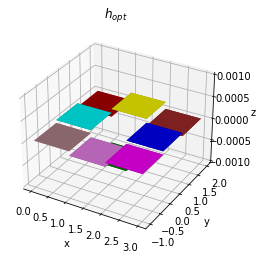

In [64]:
print(h_opt)
h_opt_graf = [x for x in h_opt]

# La cantidad de elementos que tenga esta lista es la cantidad de barras que salen.
# El elemento de cada lista corresponde a la posición dentro de la gráfica (en su respectiva coordenada).
x3 = [0, 1, 2, 0, 1, 2, 0, 1, 2]
y3 = [1, 1, 1, 0, 0, 0, -1, -1, -1]
z3 = [float(h_opt_graf[0]), float(h_opt_graf[1]), float(h_opt_graf[2]), float(h_opt_graf[3]), float(h_opt_graf[4]), float(h_opt_graf[5]), float(h_opt_graf[6]), float(h_opt_graf[7]), float(h_opt_graf[8])]

# Cuánto espacio ocupa cada barra
dx = np.ones(9)
dy = np.ones(9)
dz = np.zeros(9)

fig = plt.figure()
ax1 = fig.add_subplot(111, projection='3d')

colors = ['red', 'yellow', 'brown', 'cyan', 'green', 'blue', 'pink', 'violet', 'magenta']
ax1.bar3d(x3, y3, z3, dx, dy, dz, color=colors)
ax1.set_xlabel('x')    
ax1.set_ylabel('y')    
ax1.set_zlabel('z')
ax1.set_zlim([-10**-3, 10**-3])   
ax1.set_title('$h_{opt}$')    

[0, 1, 5, 7, 8]


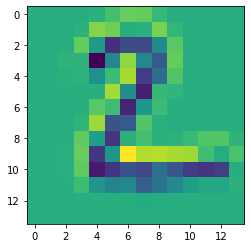

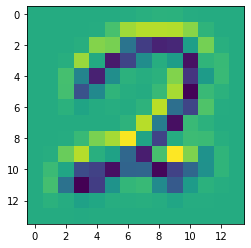

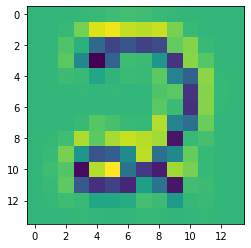

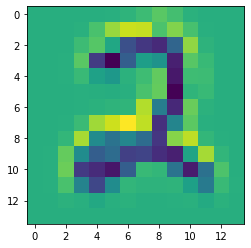

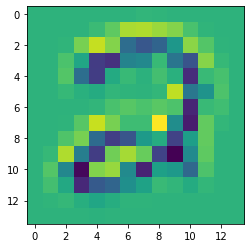

In [65]:
# Ahora vamos a mostrar algunos dígitos que se clasificaron bien, filtradas con el h_opt
print(index_bien1[:5])
k = np.array([[float(h_opt[0]), float(h_opt[1]), float(h_opt[2])], [float(h_opt[3]), float(h_opt[4]), float(h_opt[5])], [float(h_opt[6]), float(h_opt[7]), float(h_opt[8])]])
for indice in index_bien1[:5]:
    filtrada = ndimage.convolve(digitos[indice], k)
    plt.figure()
    plt.imshow(filtrada)

[100, 102, 103, 106, 108]


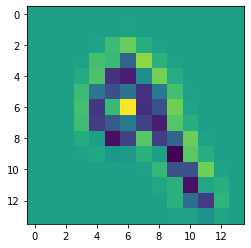

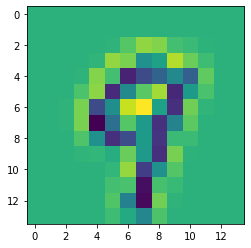

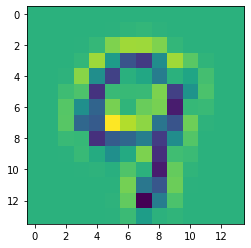

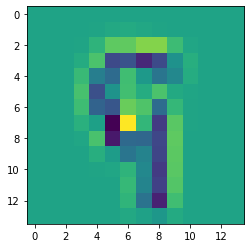

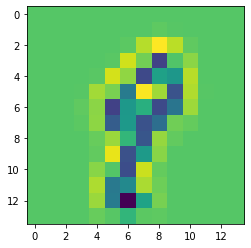

In [66]:
# Ahora vamos a mostrar algunos dígitos que se clasificaron bien, filtradas con el h_opt
print(index_bien0[:5])
k = np.array([[float(h_opt[0]), float(h_opt[1]), float(h_opt[2])], [float(h_opt[3]), float(h_opt[4]), float(h_opt[5])], [float(h_opt[6]), float(h_opt[7]), float(h_opt[8])]])
for indice in index_bien0[:5]:
    filtrada = ndimage.convolve(digitos[indice], k)
    plt.figure()
    plt.imshow(filtrada)

### Basado en estas imágenes previas, se puede decir que el tipo de operación que tiene este filtro es detección de los bordes inferiores derechos.

[2, 3, 4, 6, 11, 13, 16, 19, 21, 22, 23, 24, 28, 32, 33, 35, 36, 37, 38, 39, 41, 45, 46, 47, 48, 50, 51, 53, 56, 58, 59, 64, 66, 67, 68, 70, 71, 73, 74, 78, 81, 89, 90, 91, 93, 94, 95, 96, 99]


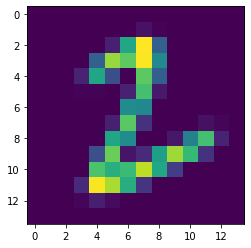

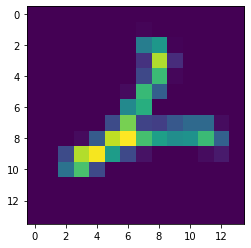

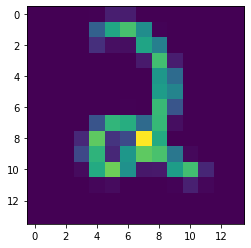

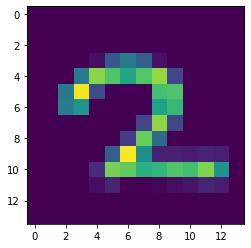

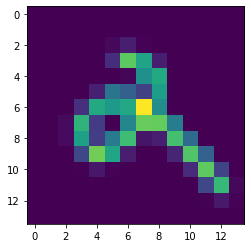

In [67]:
print(index_error1)
for indice in index_error1[:5]:
    plt.figure()
    plt.imshow(digitos[indice])

[101, 104, 105, 107, 110, 118, 121, 122, 123, 124, 126, 127, 129, 130, 131, 133, 134, 137, 138, 146, 154, 160, 163, 167, 170, 171, 172, 173, 180, 186]


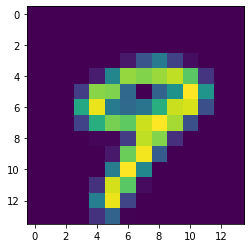

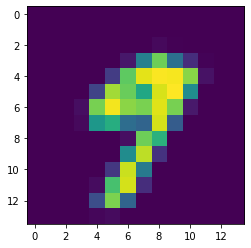

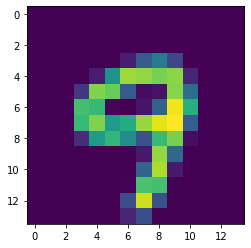

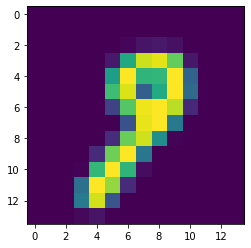

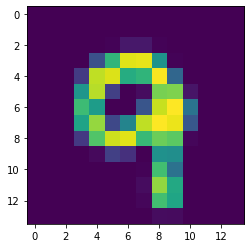

In [68]:
# Algunos dígitos en los que el algoritmo se equivocó para la clase 0 (dígitos 9).
print(index_error0)
for indice in index_error0[:5]:
    plt.figure()
    plt.imshow(digitos[indice])

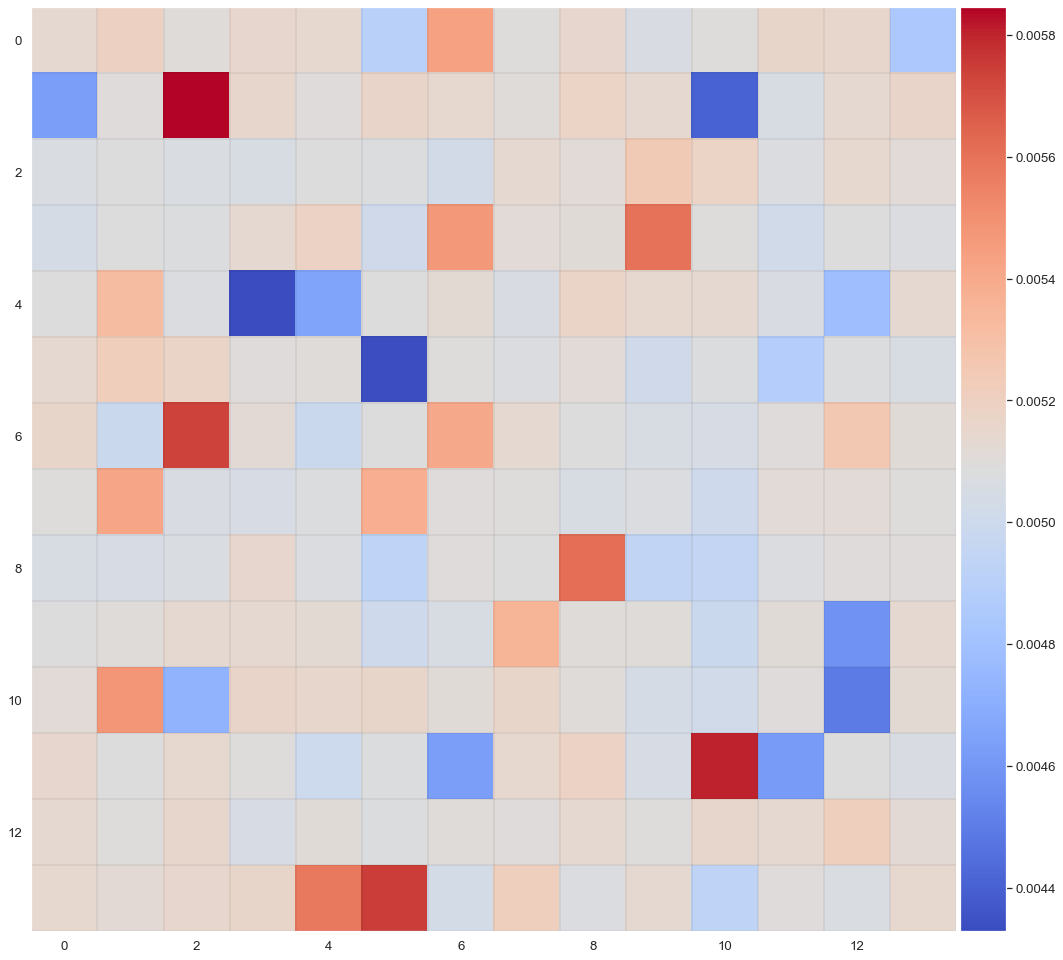

In [73]:
w = np.reshape(w_opt[:-1], (14,14))
fig  = imagesc.plot(np.abs(w))

Según la imagen anterior, las regiones en las que la red neuronal se enfoca más que todo para hacer la clasificación están cerca del centro, aunque las más importantes se encuetran en la parte inferior de la imagen y la esquina superior izquierda.